In [162]:
import os
import glob

DATA_PATTERNS = [
    "/viscam/u/ksarge/bike_symbols/1222/*/*png",
    "/viscam/u/ksarge/bike_symbols/1222/*/*jpg",
    "/viscam/u/ksarge/bike_symbols/0105/*/*jpg",
    "/viscam/u/ksarge/bike_symbols/0105/*/*png",
    "/viscam/u/ksarge/bike_symbols/1022/*/*jpg",
    "/viscam/u/ksarge/bike_symbols/1022/*/*png",
    "/viscam/projects/streetview/bike_symbol_segmentation/data/*png",
    "/viscam/projects/streetview/bike_symbol_segmentation/data/*jpg"
]
LABEL_PATTERNS = [
    "/viscam/u/ksarge/bike_symbols/*/*/*json",
    "/viscam/u/ksarge/bike_symbols/*/*/*/*json",
    "/viscam/projects/streetview/bike_symbol_segmentation/data/*json"
]

def get_files(patterns):
    files = [
        file
        for pattern in patterns
        for file in glob.glob(pattern)]
    return files

In [163]:
data_files = get_files(DATA_PATTERNS)
len(data_files)

1171

In [164]:
import collections

data_files = get_files(DATA_PATTERNS)
data_files = [data_file for data_file in data_files if '_mask' not in data_file]

label_files = get_files(LABEL_PATTERNS)

# uid_to_file = collections.defaultdict(list)
# for data_file in data_files:
#     uid_to_file[os.path.basename(data_file)].append(data_file)
    
# for key in uid_to_file:
#     files = uid_to_file[key]
#     # if any('/viscam/projects/streetview/' in file for file in files):
#     if len(files) > 1:
#         print(files)
#         raise

In [165]:
data_files

['/viscam/u/ksarge/bike_symbols/1222/1222_Updated Annotated Bike Symbols/Street View 360_Minneapolis MN_1015_44.97287275_-93.27761629.jpg',
 '/viscam/u/ksarge/bike_symbols/1222/1222_Updated Annotated Bike Symbols/Street View 360_San Francisco CA_586_37.76950634_-122.41136669.jpg',
 '/viscam/u/ksarge/bike_symbols/1222/1222_Updated Annotated Bike Symbols/Street View 360_San Francisco CA_838_37.77223067_-122.41454775.jpg',
 '/viscam/u/ksarge/bike_symbols/1222/1222_Updated Annotated Bike Symbols/Street View 360_San Francisco CA_10_37.76342371_-122.42006333.jpg',
 '/viscam/u/ksarge/bike_symbols/1222/1222_Updated Annotated Bike Symbols/Street View 360_San Francisco CA_450_37.76646861_-122.39666960.jpg',
 '/viscam/u/ksarge/bike_symbols/1222/1222_Updated Annotated Bike Symbols/Street View 360_San Francisco CA_579_37.76923260_-122.41091125.jpg',
 '/viscam/u/ksarge/bike_symbols/1222/1222_Updated Annotated Bike Symbols/Street View 360_San Francisco CA_456_37.76653417_-122.39555260.jpg',
 '/viscam

In [197]:
def get_uid(path):
    uid = os.path.basename(os.path.splitext(path)[0])
    return uid

data_uids = {get_uid(data_file) for data_file in data_files}
label_uids = {get_uid(label_file) for label_file in label_files}

print(len(data_files), len(data_uids))
print(len(label_files), len(label_uids))
print(len(data_uids.intersection(label_uids)))

uid_to_data_file = {get_uid(data_file): data_file for data_file in data_files}
uid_to_label_file = {get_uid(label_file): label_file for label_file in label_files}

uids = set.intersection(set(uid_to_data_file), set(uid_to_label_file))
DATA = []
for uid in uids:
    DATA.append((uid_to_data_file[uid], uid_to_label_file[uid]))

772 541
771 539
538


In [223]:
from PIL import Image, ImageDraw
import numpy as np

import hashlib
def get_hash(string):
    return int(hashlib.sha1(string.encode("utf-8")).hexdigest(), 16)

def get_mask(label_json):
    masks = []
    polygons = []    
    data = label_json
    # assert len(data['shapes']) == 1, f'{f} has {len(data["shapes"])} mask'
    for s in data['shapes']:
        width, height = data['imageWidth'], data['imageHeight']
        mask_img = Image.new('L', (width, height), 0)
        polygon = s['points']
        polygon = [tuple(x) for x in polygon]
        polygons.append(polygon)
        ImageDraw.Draw(mask_img).polygon(polygon, outline=1, fill=1)
        mask = np.array(mask_img)
        masks.append(mask)

    masks_all = np.stack(masks).max(axis=0)
#     metadata_this['masks'] = masks
#     metadata_this['polygons'] = polygons
    mask = Image.fromarray(masks_all.astype(np.uint8) * 255)
    return mask

DATA_DST_DIR = '/viscam/u/ksarge/bike_symbols/clean_data_dir/'
TRAIN_DIR = os.path.join(DATA_DST_DIR, "train")
TEST_DIR = os.path.join(DATA_DST_DIR, "test")
os.makedirs(TRAIN_DIR, exist_ok=True)
os.makedirs(TEST_DIR, exist_ok=True)


def process_datum(datum):
    image_path, json_label_path = datum
    with open(image_path, 'rb') as fp:
        image = Image.open(fp).convert('RGB')
    with open(json_label_path, 'r') as fp:
        json_label = json.load(fp)
    mask = get_mask(json_label)
    
    uid = get_uid(image_path)
    uid_2 = get_uid(json_label_path)
    assert uid == uid_2
    
    split = "train" if (get_hash(uid) % 5) else "test"
    
    with open(os.path.join(DATA_DST_DIR, split, f"{uid}__rgb.png"), 'wb') as fp:
        image.save(fp)
    with open(os.path.join(DATA_DST_DIR, split, f"{uid}__mask.png"), 'wb') as fp:
        mask.save(fp)
        
from multiprocessing.pool import ThreadPool
from tqdm import tqdm

with ThreadPool() as p:
    for _ in tqdm(p.imap_unordered(process_datum, DATA), total=len(DATA)):
        pass

100%|██████████| 538/538 [02:25<00:00,  3.69it/s]


In [226]:
!ls {TRAIN_DIR} | wc -l

852


In [216]:
!ls /viscam/u/ksarge/bike_symbols/clean_data_dir/train

'Street View 360_San Jose CA_436_37.31909695_-121.90834381__mask.png'
'Street View 360_San Jose CA_436_37.31909695_-121.90834381__rgb.png'


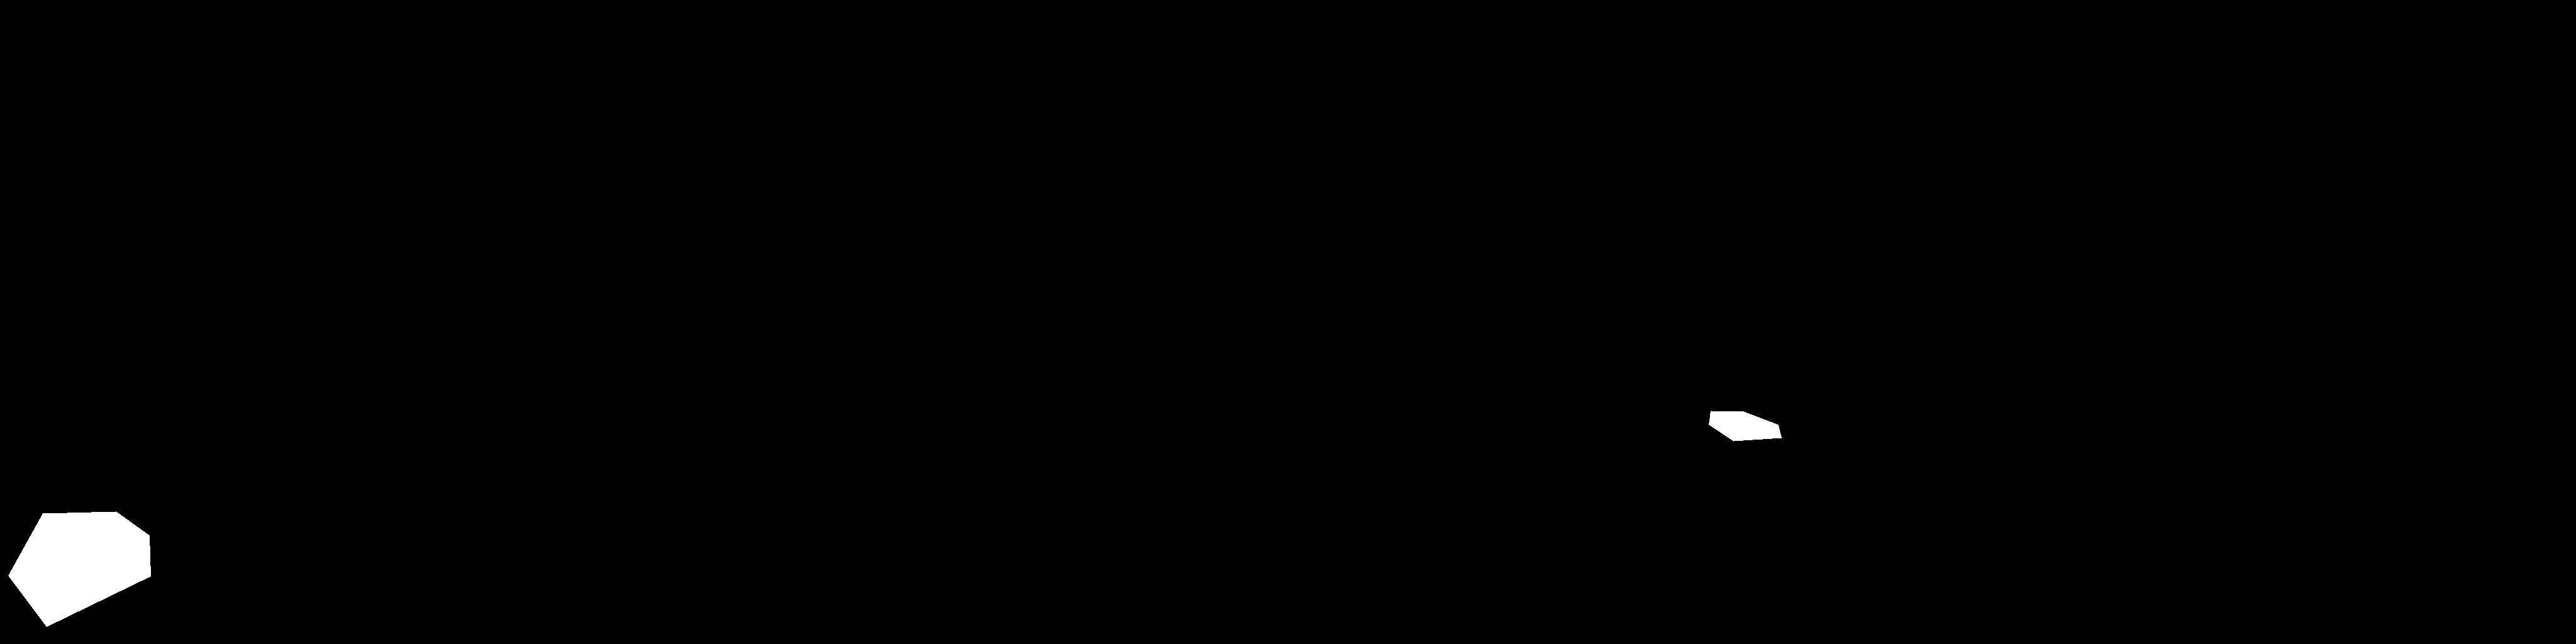

In [198]:
import json
label_file = DATA[4][1]

with open(label_file, 'r') as fp:
    label_json = json.load(fp)
    
get_mask(label_json)